# Quickstart for `pydebiaseddta`

This notebook provides a practical yet comprehensive introduction to main functionalities of `pydebiaseddta`, a Python implementation for the DebiasedDTA training training framework for robust generalization in drug-target affinity prediction tasks.

Although we will provide short descriptions of some of our modeling concepts here, please see the readme file for a reference to our paper which provide a much more extensive description of the DebiasadDTA training framework.

This notebook is intended to provide an _example_ run through DebiasedDTA pipeline. We start by a _very quick_ example run through our pipeline, and then provide a more detailed presentation of `pydebiaseddta`'s functionalities, including various visualization tools. Feel free to modify this notebook to experiment with alternative modeling choices. Lastly, please refer to `advanced_examples.ipynb` for an even more exhaustive demonstration of `pydebiaseddta`'s functionalities.

## Example run with `pydebiaseddta`, concise version

In [5]:
# Importing the required pydebiaseddta functions and classes
from pydebiaseddta.utils import load_sample_dta_data
from pydebiaseddta.evaluation import evaluate_predictions
from pydebiaseddta.debiasing import DebiasedDTA
from pydebiaseddta.guides import BoWDTA
from pydebiaseddta.predictors import DeepDTA

In [2]:
# Loading sample data, the smaller version for demonstration.
train_ligands, train_proteins, train_labels = load_sample_dta_data(mini=True, split="train")
test_ligands, test_proteins, test_labels = load_sample_dta_data(mini=True, split="test")

In [7]:
# Creating a DebiasedDTA object with BoWDTA as guide and DeepDTA as predictor.
debiaseddta = DebiasedDTA(BoWDTA, DeepDTA, predictor_params={"n_epochs": 100})
# Training the DebiasedDTA model.
train_hist = debiaseddta.train(train_ligands, train_proteins, train_labels)
# Predicting the affinities in the test set using the trained predictor.
test_preds = debiaseddta.predictor_instance.predict(test_ligands, test_proteins)
# Evaluating the predictions of our model.
scores = evaluate_predictions(test_labels, test_preds, metrics=["ci", "r2", "mae", "rmse"])

Guide training started.


Guide training completed in 00:00:13.
Predictor training started.


100%|██████████| 100/100 [00:22<00:00,  4.35it/s]

Predictor training completed in 00:00:23.


In [9]:
print(f"Performance of the model:")
for metric, score in scores.items():
    print(metric.upper() + ":", round(score, 4))

Performance of the model:
CI: 0.6364
R2: -0.0556
MAE: 0.4968
RMSE: 0.6075


## Example run with `pydebiaseddta`, extended version

### Loading the data

For these demonstrations we will use a sample from the KIBA dataset that is provided with our repository. Our data loader, `load_sample_dta_data` loads a tiny and somewhat larger version of our dataset based on the parameter `mini`. The default demonstrations below will be on either the smaller or larger version of our sample dataset. However, see our readme file for a downloadable link to the full BDB and KIBA datasets that include training, validation, and test splits based on novelty of the ligands and proteins in question, which you can use for your own experiments.

We start by loading the sample data:

In [1]:
from pydebiaseddta.utils import load_sample_dta_data
from pydebiaseddta.evaluation import evaluate_predictions

train_ligands, train_proteins, train_labels = load_sample_dta_data(mini=True, split="train")
val_ligands, val_proteins, val_labels = load_sample_dta_data(mini=True, split="val")
test_ligands, test_proteins, test_labels = load_sample_dta_data(mini=True, split="test")

Let us now import three classes: `DebiasedDTA`, `BoWDTA`, and `DeepDTA`.

In [7]:
from pydebiaseddta.debiasing import DebiasedDTA
from pydebiaseddta.guides import BoWDTA
from pydebiaseddta.predictors import DeepDTA

`DebiasedDTA` is the central class for this package. It coordinates the training of the **guide** model to obtain importance weights, uses those importance weights to train the **predictor** model, and then can obtain predictions from the trained predictor for previously unseen data.

In this example, we use `BoWDTA` and `DeepDTA` for our guide and predictor models respectively. `BoWDTA` conducts predictions based on a decision tree regressor using a bag-of-words representation of ligands and proteins. The errors from this simplistic model then is used by `DebiasedDTA` to compute importance weights of the input instances. Inputs which incur high errors when predicted by this simplistic model are likely to contain valuable relationships that cannot be captured by simple associations (i.e. "shortcut learning"). DeepDTA (https://academic.oup.com/bioinformatics/article/34/17/i821/5093245) is an often cited drug-target affinity prediction model that uses the string representation of ligands and proteins.

Feel free to experiment with guide alternatives `IDDTA`, `RFDTA`, `OutDTA` (or `None` if no importance weighting is desired) and predictor alternatives `BPEDTA` and `LMDTA`. Additionally, notice that `pydebiaseddta` allows using predictors as guides to allow the user to utilize the errors of early-stopped predictor models to compute importance weights. Moreover, guide models can be used as predictors to compute their baseline performances. When you use a guide model as predictor, make sure you do not use another guide class, by inputting `None`.

### Initializing `DebiasedDTA` object



Let us initialize our DebiasedDTA object, where we make some example choices in our experiment parameters, which we will examine afterwards.

In [10]:
debiaseddta = DebiasedDTA(
    BoWDTA,
    DeepDTA,
    guide_params={
        "max_depth": 8,
        "vocabulary_size": "high",
        "criterion": "squared_error",
        },
    predictor_params={
        "n_epochs": 200,
        "learning_rate": 0.001,
        "optimizer": "adam",
        "batch_size": 100,
        "early_stopping_num_epochs": 10,
        "early_stopping_metric": "mse",
        "early_stopping_split": "val",
        },
    n_bootstrapping=10,
    weight_tempering_exponent=0.50,
    weight_temperature=0.75,
    seed=0
    )

Having initialized our DebiasedDTA object, let us examine these parameters we provided and examine their effects on the training procedure. Our first two inputs are `BoWDTA` and `DeepDTA`, which are the classes for the guide and predictor models. Next, we have `guide_params` dictionary, which provides hyperparameters for the training of the guide model, affecting the resulting importance weights. Here, `max_depth` limits the depth of the random tree regressor, leading to a simple guide model. Similarly, setting `vocabulary_size` to "high" lets the model conduct tokenization through a large dictionary; if desired this can be set to "low" to further limit the complexity of the representations it can acquire. Lastly, `criterion` parameter determines the loss according to which Guide can be trained. Not all experiments will call for changing the default values for these hyperparameters, for a more detailed view of these parameters, see the `guides` module.

Next, we provided hyperparamaters to the training of the predictor through `predictor_params`. These include the self-explanatory `n_epochs`, `learning_rate`, `batch_size`, and `optimizer`. We also provided the hyperparameters `early_stopping_num_epochs`, `early_stopping_metric`, and `early_stopping_split` parameters. The former two ensure that the training will terminate early if no improvement in the MSE metric is observed for 10 epochs. The latter indicates that this decision will be made based on the "val" split. The only split the predictor training assumes by default is "train", so we will have to provide the "val" split explicitly when starting the training, which we will do below. See the `predictors` module for more hyperparameters and their effects.

Lastly, we provide `n_bootstrapping`, `weight_tempering_exponent`, and `weight_temperature` hyperparameters. These are among the hyperparameters that govern the overall Debiased training procedure. Although these can be left to their default values unless there is an explicit reason not to, we make them explicit here for demonstration purposes. `n_bootstrapping` determines how many train-test splits will the guide errors be computed over to create importance weights. Our selections for `weight_tempering_exponent` and `weight_temperature` here ensure that during the training, importance weights will transition quickly from uniform to computed importance weights, which themselves are made to be "low-temperature", further away from uniform. We also provide `seed` parameter to control randomness for reproducability: we provide this to the constructor so that the randomness in the initialization of predictor algorithm is also factored in. For a detailed description of these hyperparameters and more, see the `debiasing` module.

### Training the `DebiasedDTA` model

We now start the training for the combined DebiasedDTA model. `train` method of our model will accept ligands, proteins, and labels of the training set. Additionally, we provide the validation splits we desire as a dictionary of lists, as demonstrated above. We explicitly provide the metrics which we want tracked, and we also specify save paths for our importance weights and trained predictor model to be able to access them later. Be aware that by default his code trains with a very small dataset for demonstration purposes, and we will conduct training with a somewhat larger dataset after our demonstration in this section.

In [11]:
train_hist = debiaseddta.train(
    train_ligands,
    train_proteins,
    train_labels,
    val_splits = {"val": [val_ligands, test_proteins, test_labels]},
    metrics_tracked=["mae", "mse", "r2"],
    predictor_save_folder="./temp/example_run/",
    weights_save_path="./temp/example_run/importance_weights.coef",
    )

Guide training started.
Saved importance weights to ./temp/example_run/importance_weights.coef.
Guide training completed in 00:00:13.
Predictor training started.


 12%|█▎        | 25/200 [00:14<00:48,  3.60it/s]

Early stopping due to no increase to mse in val split for 10 epochs.


 12%|█▎        | 25/200 [00:15<01:47,  1.62it/s]


Retrieved the best model from epoch 15.
Saved predictor to the folder ./temp/example_run/.
Predictor training completed in 00:00:16.


### Evaluating the `DebiasedDTA` model

We now obtain the predictions of the model for the test set, and examine its performance according to concordance index (CI), $R^2$, mean absolute error (MAE), and root mean squared error (RMSE).

In [12]:
test_preds = debiaseddta.predictor_instance.predict(test_ligands, test_proteins)
scores = evaluate_predictions(test_labels, test_preds, metrics=["ci", "r2", "mae", "rmse"])   
print(f"Performance of the model:")
for metric, score in scores.items():
    print(metric.upper() + ":", round(score, 4))

Performance of the model:
CI: 0.6364
R2: 0.0656
MAE: 0.489
RMSE: 0.5715


### Comparing with baselines

Let us try train two baseline models to compare with our model above:
- The first baseline model will be using BoWDTA directly to estimate affinity scores in the test set.
- The second one will be a DeepDTA model where no importance weighting takes place - here we will not be specifying guide-related parameters, nor will we be providing parameters regarding how importance weights are handled, as this will be the default training with no importance weighting.




In [13]:
debiaseddta_baseline = DebiasedDTA(None, BoWDTA, predictor_params={"max_depth": 8, "vocabulary_size": "high", "criterion": "squared_error"})
train_hist = debiaseddta_baseline.train(train_ligands, train_proteins, train_labels, metrics_tracked=["mae", "mse", "r2"],)
test_preds = debiaseddta_baseline.predictor_instance.predict(test_ligands, test_proteins)
scores = evaluate_predictions(test_labels, test_preds, metrics=["ci", "r2", "mae", "rmse"])   

print(f"\nPerformance of the BoWDTA baseline:")
for metric, score in scores.items():
    print(metric.upper() + ":", round(score, 4))

No guide model specified, proceeding with uniform weights.
Predictor training started.
Predictor training completed in 00:00:00.

Performance of the BoWDTA baseline:
CI: 0.1591
R2: -1.9083
MAE: 0.7766
RMSE: 1.0083


In [14]:
debiaseddta_baseline = DebiasedDTA(None, DeepDTA, 
    predictor_params={"n_epochs": 200, "learning_rate": 0.001, "optimizer": "adam", "batch_size": 100,
        "early_stopping_num_epochs": 10, "early_stopping_metric": "mse", "early_stopping_split": "val"})
train_hist = debiaseddta_baseline.train(train_ligands, train_proteins, train_labels,
    val_splits = {"val": [val_ligands, test_proteins, test_labels]},
    metrics_tracked=["mae", "mse", "r2"],
    predictor_save_folder="./temp/example_run_baseline/")
test_preds = debiaseddta_baseline.predictor_instance.predict(test_ligands, test_proteins)
scores = evaluate_predictions(test_labels, test_preds, metrics=["ci", "r2", "mae", "rmse"])   
print(f"\nPerformance of the DeepDTA baseline:")
for metric, score in scores.items():
    print(metric.upper() + ":", round(score, 4))

No guide model specified, proceeding with uniform weights.
Predictor training started.


 12%|█▎        | 25/200 [00:14<00:48,  3.62it/s]

Early stopping due to no increase to mse in val split for 10 epochs.


 12%|█▎        | 25/200 [00:15<01:47,  1.63it/s]


Retrieved the best model from epoch 15.
Saved predictor to the folder ./temp/example_run_baseline/.
Predictor training completed in 00:00:16.

Performance of the DeepDTA baseline:
CI: 0.6364
R2: 0.0055
MAE: 0.5115
RMSE: 0.5897


Observe that the debiased model's performance is unsurprisingly much better than the BoWDTA baseline. The debiased model also seems to have performed better than the default DeepDTA model. Although the sample dataset used here is too small for any realistic experimentation, this set of experiments provide an example scenario of experimentation with `pydebiaseddta`. We will now train with a somewhat larger dataset for the visualization experiments below.

### Visualization

We can also use the visualization tools provided by `pydebiaseddta` to examine our data and our model's predictions further. Let us first load the larger version of our example dataset and start with an examination of the unique counts of ligands and proteins, as well as affinity scores in our sample dataset.

Unlike the above experiments, the visualization functions take the full DataFrames for the dataset splits in question. When we provide no splits to `load_sample_dta_data`, we obtain a dictionary that includes all datasets in DataFrame format.

In [1]:
# Importing the required pydebiaseddta functions and classes
from pydebiaseddta.utils import load_sample_dta_data, load_sample_prot_sim_matrix, compute_average_distances
from pydebiaseddta.debiasing import DebiasedDTA
from pydebiaseddta.guides import BoWDTA
from pydebiaseddta.predictors import DeepDTA
from pydebiaseddta.visualization import ligand_protein_affinity_histograms, plot_prevalent_affinities, plot_distance_error_split
import numpy as np
# When we do not provide a split, the function returns a dictionary of DataFrames including all splits.
data = load_sample_dta_data()
train_data, val_data, test_data = data["train"], data["val"], data["test"]

#### Visualizing data histograms

We now plot the ligand, histogram, and affinity score histograms.

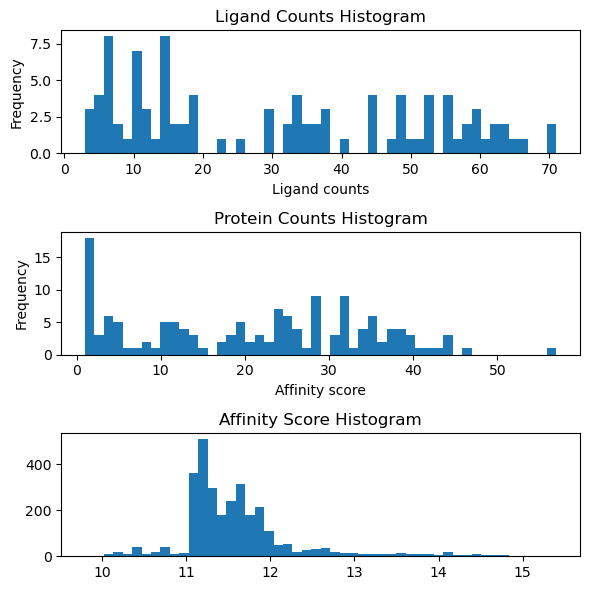

In [2]:
_ = ligand_protein_affinity_histograms(train_data)

We can see that both ligands and proteins in our dataset present a wide variety in terms of how prevalent they are. While we have a lot of ligands and proteins that are encountered less than 5 times, we also have examples that are encountered more than 50 times. Also, affinity scores seem to be centered around 11.2, however there seems to be a moderately large spread around this value.

#### Visualizing existing _and_ predicted affinities

The following two visualizations will require us to provide a trained predictor model. So let us now train a DebiasedDTA model on this larger data sample.

In [ ]:
debiaseddta = DebiasedDTA(BoWDTA, DeepDTA,
    guide_params={"max_depth": 6, "vocabulary_size": "high"},
    predictor_params={"n_epochs": 200, "learning_rate": 0.001, "optimizer": "adam", "batch_size": 200,
        "early_stopping_num_epochs": 20, "early_stopping_metric": "mse", "early_stopping_split": "val"},
    n_bootstrapping=5, seed=0)

# debiaseddta.predictor_instance = DeepDTA.from_file("./temp/example_run_large/")
train_hist = debiaseddta.train(
    train_data.smiles.tolist(),
    train_data.aa_sequence.tolist(),
    train_data.affinity_score.tolist(),
    val_splits = {"val": [val_data.smiles.tolist(), val_data.aa_sequence.tolist(), val_data.affinity_score.tolist()]},
    metrics_tracked=["mae", "mse", "r2"],
    predictor_save_folder="./temp/example_run_large/",
    weights_save_path="./temp/example_run_large/importance_weights.coef",
    )

The next visualization helps us visualize the affinities between the $k$ most prevalent proteins and ligands. Although any dataset is likely to include a lot of the affinities between the most prevalent proteins and ligands, there still bound to be missing affinity values between certain ligands and proteins. For these, we can have a trained model predict these interactions and visualize with our model having filled the missing data, allowing us to both see the affinities between most prevalent ligands and proteins, as well as how our model interpolates missing data in such situations.

In [4]:
# Remember that we can also load a saved model, e.g. predictor = DeepDTA.from_file("./temp/example_run_large")
predictor = debiaseddta.predictor_instance

: 

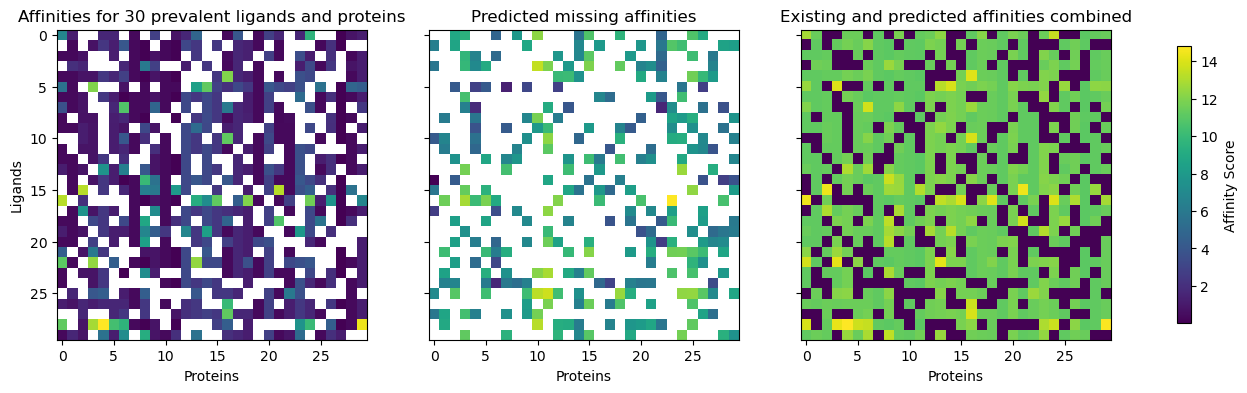

In [5]:
prevalent_ligands, prevalent_proteins, fig = plot_prevalent_affinities(
    train_data, 
    k_prevalence=30,
    predictor=predictor,
    )

#### Visualizing average distances, errors, and splits

Given a useful definition of ``distance'' between ligands and proteins, how does the average distances of ligands/proteins from the training set affect the model's prediction performance? In the following, we first use our `compute_average_distances` function to compute the average distance of the ligand and protein in each interaction to the ligands and proteins in the training set. As a notion of distance, this function uses the Tanimoto distance based on Morgan fingerprints for ligands, and 1 - Smith-Waterman similarity for proteins.

We will do these computations for train and test splits. Because we provide a "cold" test split, that is, test split includes ligands and proteins that are not included in the train set, the average distances of test set's inputs are likely to be larger. In addition, we can examine the relationship between these distances and the error the model incurs when conducting prediction on these examples. We now compute the average distances, obtain the trained model's predictions, and compute the absolute error for each instane in the train and test data splits.

In [2]:
prot_sim_matrix = load_sample_prot_sim_matrix()

for data_split in [train_data, test_data]:
    data_split["avg_ligand_distance"], data_split["avg_protein_distance"] = compute_average_distances(data_split, prot_sim_matrix, train_data)
    data_split["pred_affinity_score"] = np.array(predictor.predict(ligands=data_split.smiles.tolist(), proteins=data_split.aa_sequence.tolist())).flatten()
    data_split["abs_error"] = np.abs(data_split["pred_affinity_score"] - data_split["affinity_score"])

We can then use these information for visualization using the `plot_distance_error_split` function from the `visualization` module. 

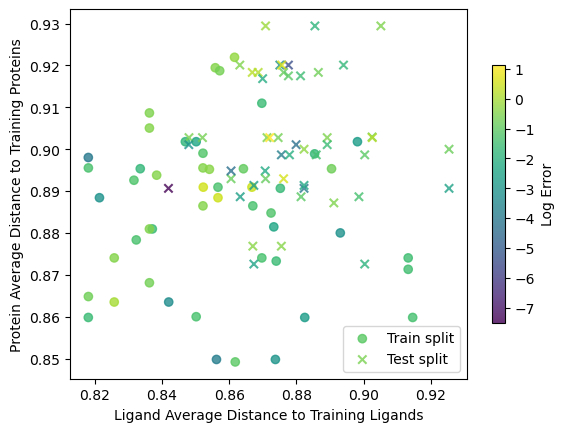

In [3]:
_ = plot_distance_error_split(
    {"Train split": train_data, "Test split": test_data},
    error_col="abs_error",
    sample_per_split=50,
    )

Although it is hard to extract robust patterns given the small size of the data, the train set examples indeed seem to be closer in average to their own split's instances. Moreover, the overall lighter color of the test split denotes the increased errors encountered when predicting the test set. There is a rough pattern favoring closer molecules in terms of the errors incurred, however this is harder to establish and requires scrutiny in a larger experimental setting which our pipeline expedites.